In [1]:

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from detection_lib import *
%matplotlib inline

In [3]:
#Import the training data
cars = glob.glob('./data/vehicles/*/*.png')
notcars = glob.glob('./data/non-vehicles/*/*.png')
print('Number of Vehicle Images: ',len(cars))
print('Number of Non-Vehicle Images: ',len(notcars))

Number of Vehicle Images:  8792
Number of Non-Vehicle Images:  8968


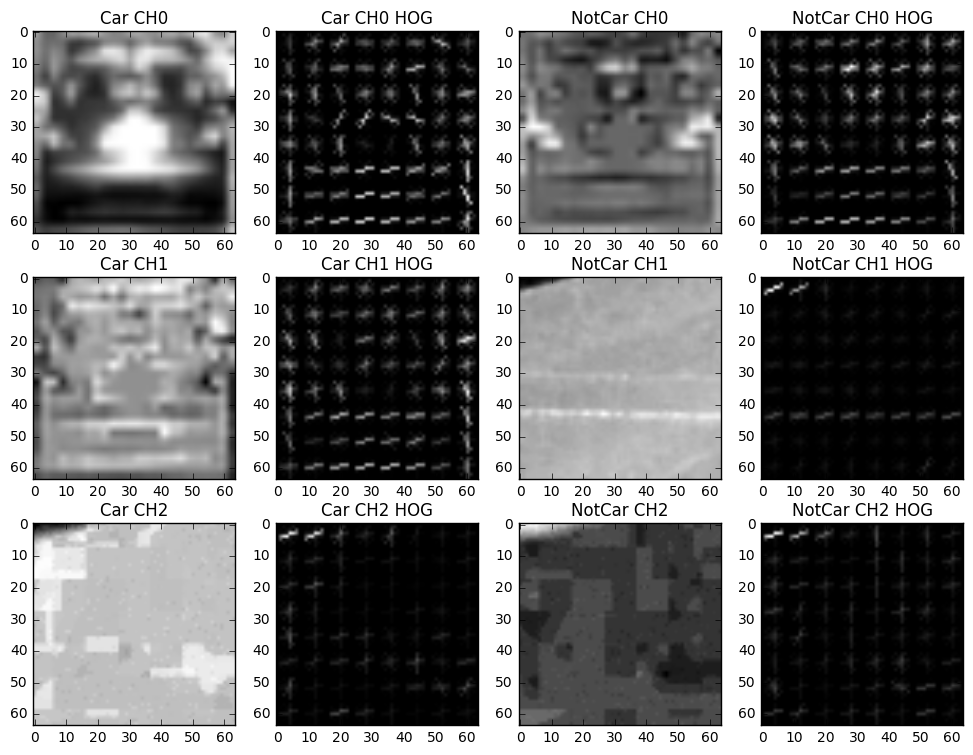

In [15]:
### Extract HOG feature only from Random image
car_id = np.random.randint(0,len(cars))
notcar_id = np.random.randint(0,len(notcars))
#RGB image
car_image = mpimg.imread(cars[car_id])
notcar_image = mpimg.imread(notcars[notcar_id])

orient = 9
pix_per_cell = 8
cell_per_block = 2

# Can be RGB, HSV, LUV, HLS, YUV, YCrCb
car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)
notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2YCrCb)

car_hog_image = []
notcar_hog_image = []
for i in range(len(car_image.shape)):    
    #Car
    features, img = get_hog_features(car_image[:,:,i], orient, pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=True)
    car_hog_image.append(img)
    # not car
    features, img = get_hog_features(notcar_image[:,:,i], orient, pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=True)
    notcar_hog_image.append(img)
    
#plot the results
imgs = [car_image[:,:,0],car_hog_image[0],car_image[:,:,1],car_hog_image[1],car_image[:,:,2],car_hog_image[2],
       notcar_image[:,:,0],notcar_hog_image[0],notcar_image[:,:,1],notcar_hog_image[1],notcar_image[:,:,2],notcar_hog_image[2]]
titles = ['Car CH0','Car CH0 HOG','NotCar CH0','NotCar CH0 HOG',
         'Car CH1','Car CH1 HOG','NotCar CH1','NotCar CH1 HOG',
         'Car CH2','Car CH2 HOG','NotCar CH2','NotCar CH2 HOG',]
fig = plt.figure(figsize=(12,9))
hog_visualize(fig, 3, 4, imgs, titles)

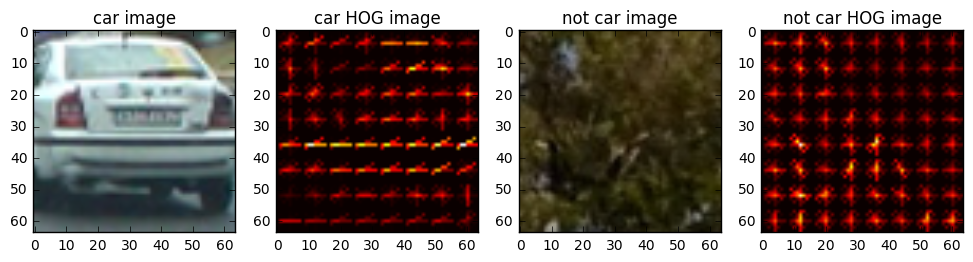

In [25]:
#paly with different feature combination
car_id = np.random.randint(0,len(cars))
notcar_id = np.random.randint(0,len(notcars))
#RGB image
car_image = mpimg.imread(cars[car_id])
notcar_image = mpimg.imread(notcars[notcar_id])

color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,vis=True)

notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat,vis=True)
#visulize
images = [car_image,car_hog_image,notcar_image,notcar_hog_image]
titles = ['car image','car HOG image','not car image','not car HOG image']
fig = plt.figure(figsize=(12,3))
visualize(fig,1,4,images,titles)

In [4]:
#train a classifier

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
#n_samples = 1000
#random_indx=np.random.randint(0,len(cars),n_samples)
#test_cars = np.array(cars)[random_indx]
#test_notcars = np.array(notcars)[random_indx]

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t, 'Seconds to compute features')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell', cell_per_block,'cells per block',
     hist_bins,'histogram bins, and', spatial_size,'spacial sampling')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))





120.3703179359436 Seconds to compute features
Using: 9 orientations 8 pixels per cell 2 cells per block 32 histogram bins, and (32, 32) spacial sampling
Feature vector length: 8460
35.02 Seconds to train SVC...
Test Accuracy of SVC =  0.9916


0.757918119430542 seconds to process on image searching 100 windows
0.8063690662384033 seconds to process on image searching 100 windows
0.7632310390472412 seconds to process on image searching 100 windows
0.7161180973052979 seconds to process on image searching 100 windows
0.688230037689209 seconds to process on image searching 100 windows
0.6933109760284424 seconds to process on image searching 100 windows


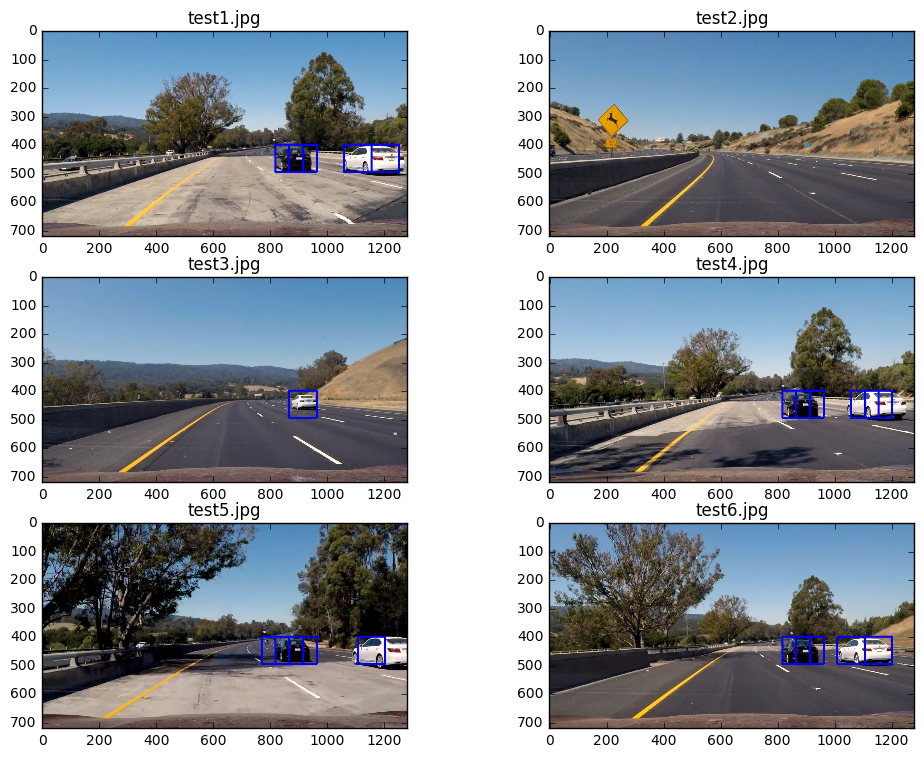

In [8]:
#test on test images
test_images = glob.glob('./test_images/*')
images = []
titles = []
y_start_stop=[400, 656]
overlap = 0.5

for img_src in test_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(overlap, overlap))
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)
    
    window_img = draw_boxes(draw_img,hot_windows,color=(0,0,255),thick=6)
    images.append(window_img)
    titles.append(img_src[-9:])
    print(time.time()-t1,'seconds to process on image searching',len(windows),'windows')
fig = plt.figure(figsize=(12,9),dpi=300)
visualize(fig,3,2,images,titles)


0.5683128833770752 seconds to run, total windows =  294
0.5936689376831055 seconds to run, total windows =  294
0.5510909557342529 seconds to run, total windows =  294
0.5319640636444092 seconds to run, total windows =  294
0.5143680572509766 seconds to run, total windows =  294
0.504241943359375 seconds to run, total windows =  294


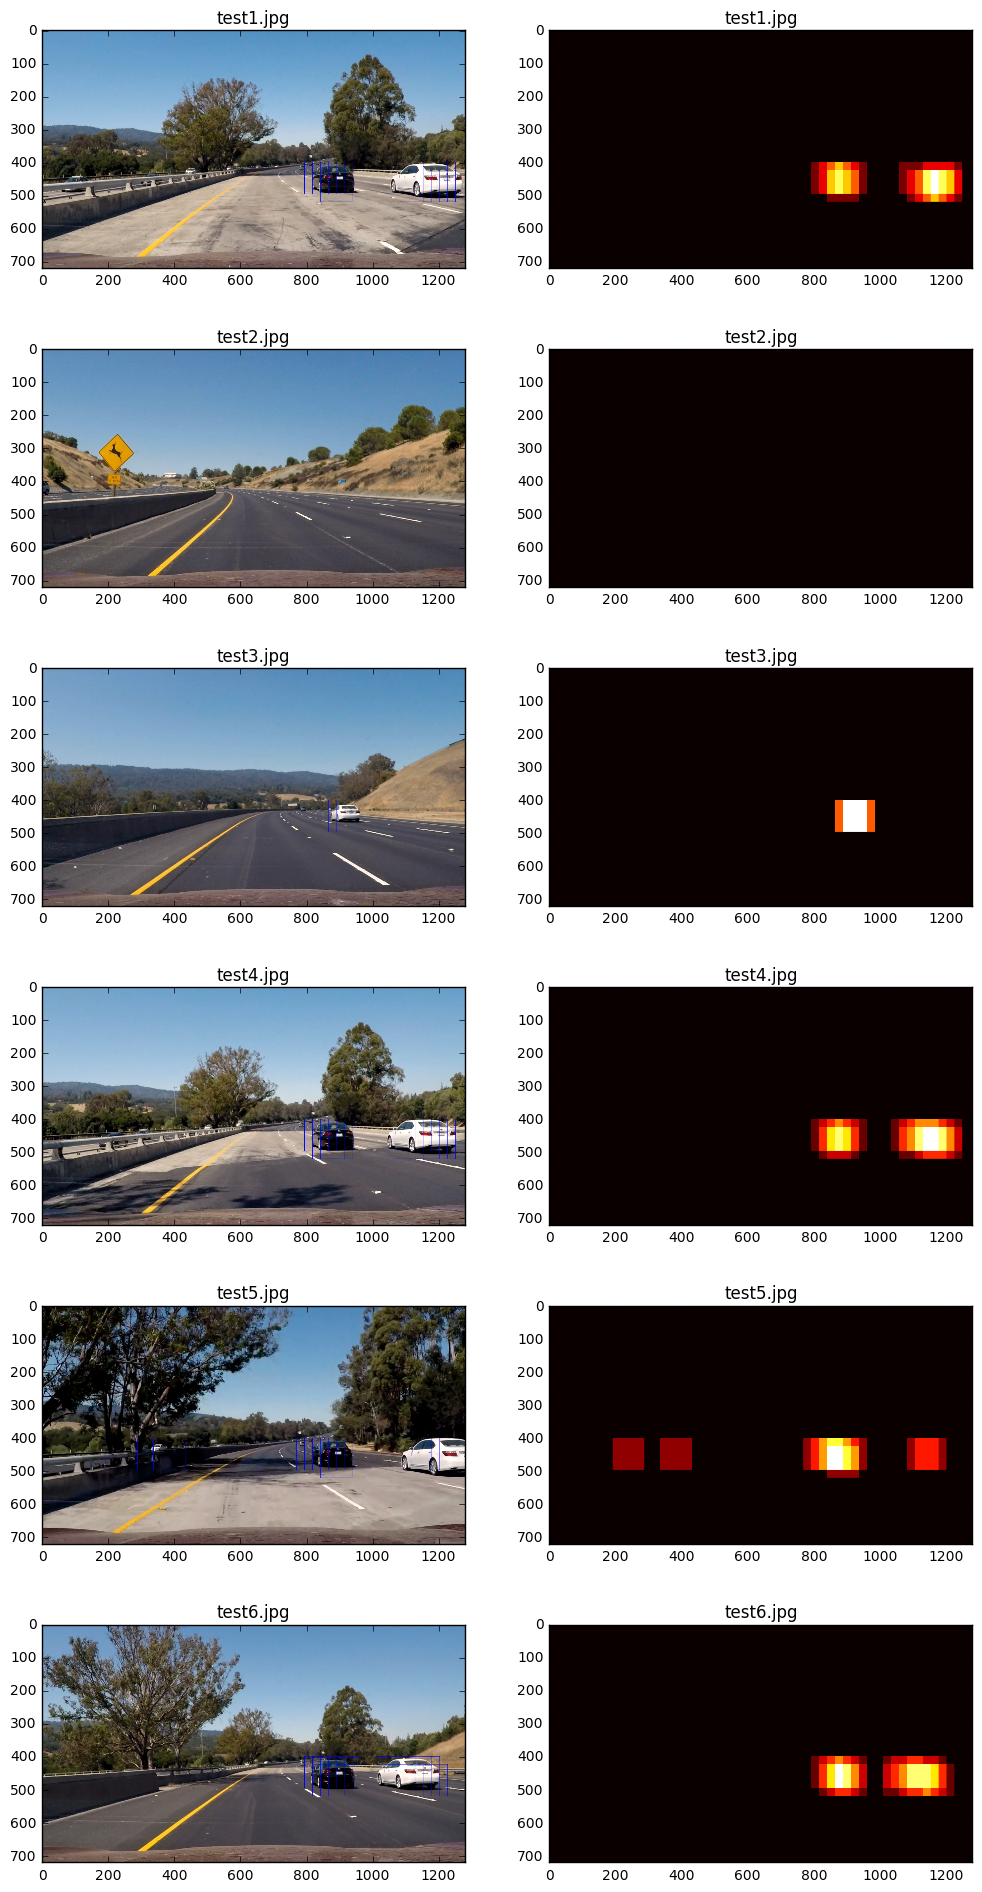

In [7]:
#implement heat map
test_images = glob.glob('./test_images/*')
out_images = []
out_maps = []
out_titles = []
out_boxes = []
ystart = 400
ystop = 656
scale = 1.5

for img_src in test_images:
    img_boxes = []
    t = time.time()
    count = 0
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    #heat map
    heatmap = np.zeros_like(img[:,:,0])
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
        
    #define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
        
    ##compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec = False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec = False)
        
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            #Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1,hog_feat2,hog_feat3))
                
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
                
            #Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window,xleft:xleft+window], (64,64))
                
            #get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
                
            #scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features,hist_features,hog_features)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
                
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255))
                img_boxes.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw] += 1
                    
    print(time.time()-t, 'seconds to run, total windows = ', count)
        
    out_images.append(draw_img)
    out_titles.append(img_src[-9:])
    out_titles.append(img_src[-9:])
        
    out_images.append(heatmap)
    out_maps.append(heatmap)
    out_boxes.append(img_boxes)
        
fig = plt.figure(figsize=(12,24))
visualize(fig,6,2,out_images,out_titles)
    

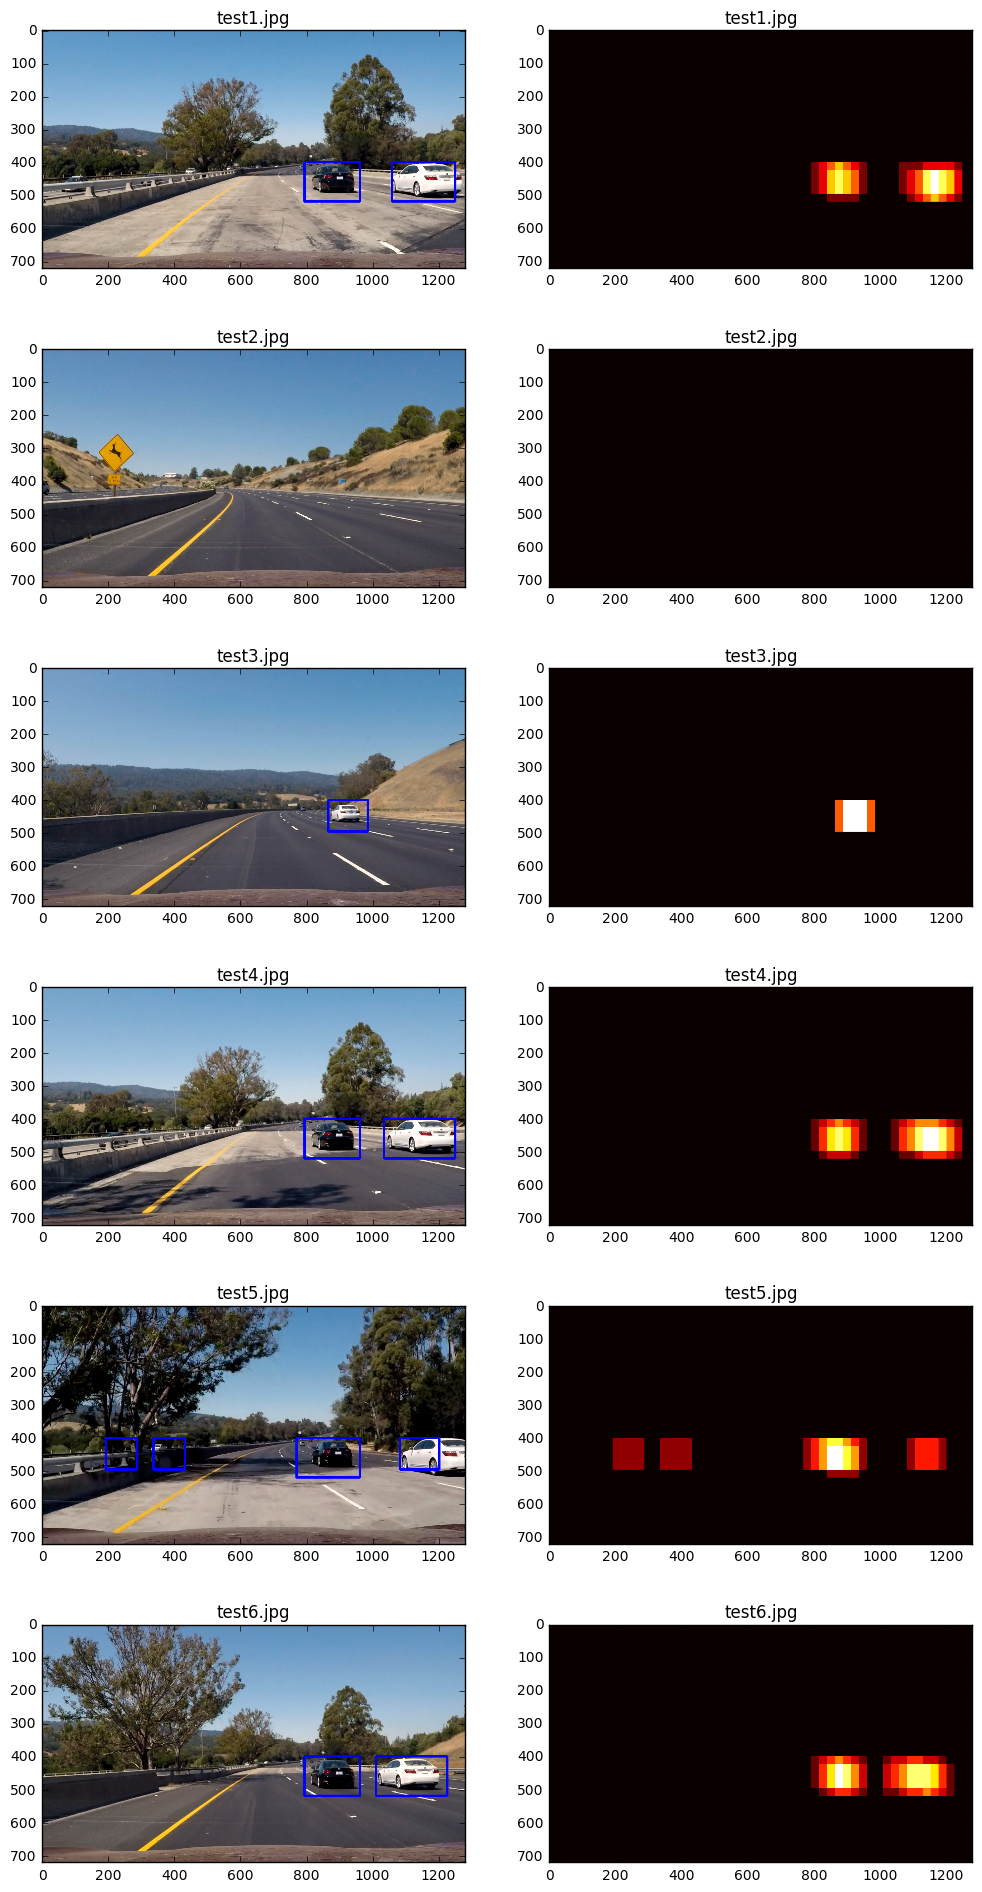

In [36]:
out_images = []
out_maps = []
ystart = 400
ystop = 656
scale = 1.5
#iterative over test images
for img_src in test_images:
    img = mpimg.imread(img_src)
    out_img,heat_map = find_cars(img,scale)
    labels = label(heat_map)
    #draw bounding box on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img),labels)
    out_images.append(draw_img)  
    out_images.append(heat_map)
    
fig = plt.figure(figsize=(12,24))
visualize(fig,6,2,out_images,out_titles)

In [54]:
# test video
video = Image()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
test_output = 'test_video_solution.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(video.process_image)
%time white_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_video_solution.mp4
[MoviePy] Writing video test_video_solution.mp4


 97%|█████████▋| 38/39 [00:18<00:00,  2.04it/s]      | 1/39 [00:00<00:19,  1.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_solution.mp4 

CPU times: user 1min 13s, sys: 2.07 s, total: 1min 15s
Wall time: 19.9 s


In [60]:
# project video
video = Image()
test_output = 'project_video_solution.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(video.process_image)
%time white_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_video_solution.mp4
[MoviePy] Writing video project_video_solution.mp4


100%|█████████▉| 1260/1261 [16:56<00:00,  1.25it/s]    | 1/1261 [00:00<10:31,  2.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_solution.mp4 

CPU times: user 59min 39s, sys: 2min 30s, total: 1h 2min 9s
Wall time: 16min 57s
